# Walmart Trip Type Classification - Data Wrangling
### Capstone Project - 1
### By: * Rajesh Dharmarajan *
******************
_This is my first capstone project for Springboard Career Track. This is a classification problem with Data from Walmart to predict the Trip Type. This is orginally from a Kaggle competition_

** Overview **


Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types. 

Whether they're on a last minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.

Currently, Walmart's trip types are created from a combination of existing customer insights ("art") and purchase history data ("science"). 

The challenge here is to classify customer trips using only a transactional dataset of the items they've purchased.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification


In [193]:
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import seaborn as sns

** Read the file **

In [194]:
df_walmart_raw = pd.read_csv('wm_train.csv')

**Data fields**

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
* VisitNumber - an id corresponding to a single trip by a single customer
* Weekday - the weekday of the trip
* Upc - the UPC number of the product purchased
* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
* DepartmentDescription - a high-level description of the item's department
* FinelineNumber - a more refined category for each of the products, created by Walmart

In [195]:
df_walmart_raw.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [110]:
df_walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB




Lets look at the data
****

In [196]:
unique_trips = len(df_walmart_raw.VisitNumber.unique())# number of unique trips - 95,674

In [197]:
unique_UPC = len(df_walmart_raw.Upc.unique())# number of unique UPC - 97,715

In [199]:
unique_FilelineNumber = len(df_walmart_raw.FinelineNumber.unique()) # number of unique FinelineNumber - 5,196

In [198]:
unique_TripTypes = len(df_walmart_raw.TripType.unique())#38 different types of Trips

In [200]:
unique_departments = len(df_walmart_raw.DepartmentDescription.unique())#69 different types of departments

There are rows where both the UPC and Depeartment Description does not contain any value. Remove these rows from the 
data since, without knowning what the customer bought or returned, the trip cannot be classified. So, discard these rows

In [301]:
df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())|(df_walmart_raw.DepartmentDescription.notnull())]

In [302]:
no_of_obs = len(df_walmart_1st_cleanse) # 645,693 observations after dropping the ones with null UPCs

In [303]:
unique_nonnull_trips = len(df_walmart_1st_cleanse.VisitNumber.unique())# number of unique trips - 95,674

In [304]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645693 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 645693 non-null int64
VisitNumber              645693 non-null int64
Weekday                  645693 non-null object
Upc                      642925 non-null float64
ScanCount                645693 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.4+ MB


****
## UPC that occur just once
there are a large number of UPCs that occur only once, analyze this data so see if there is any pattern

In [305]:
#get all the UPCs that show up just one and store it as a series
#the UPC will be the key(axes) and the number of times it occurs
#i.e. 1 will be the value
count_series = df_walmart_1st_cleanse.Upc.value_counts()

In [306]:
count_series = count_series[count_series.values<2]

In [307]:
#get the UPCs into a list
upc_once_occurs_list = count_series.axes[0]

In [308]:
#get the list of VisitNumbers that have the UPCs that occcur just once
upc_once_visits = df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(upc_once_occurs_list)].VisitNumber.unique()

In [309]:
len(upc_once_occurs_list)
# there are 37,080 UPCs that occur only once, total unique UPCs - 97,715

37080

In [310]:
len(upc_once_visits)
#22,415 visits contain UPCs that occur only once, total number of visits in this data 95,674

22415

In [311]:
#get the dataframe with all the Visits that have UPCs that occur once
df_wm_upc_once = df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(upc_once_visits)]

In [312]:
df_wm_upc_once.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0


#### From the above data, it looks like UPCs occuring once does not have much effect on the Trip Type classification
****

## Lets look at the number of items for each VisitNumber 



In [313]:
df_visits = pd.DataFrame(df_walmart_1st_cleanse.VisitNumber.value_counts().axes[0]) 

In [314]:
df_visits.columns = ['VisitNumber']

In [315]:
df_visits['no_of_items']=df_walmart_1st_cleanse.VisitNumber.value_counts().values
#df_walmart_1st_cleanse.VisitNumber.value_counts().values

In [316]:
df_visits['TripType']=df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(df_visits.VisitNumber)].TripType
#df_visits[0]

In [317]:
df_visits['Day']=df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(df_visits.VisitNumber)].Weekday

In [318]:
df_visits.head()

,VisitNumber,no_of_items,TripType,Day
0,72439,209,999.0,Friday
1,88011,151,30.0,Friday
2,9181,113,30.0,Friday
3,60971,112,26.0,Friday
4,65792,109,26.0,Friday


In [267]:
len(df_visits)

95516

** Check if there is a correlation between 'number of items' and the Trip Type **

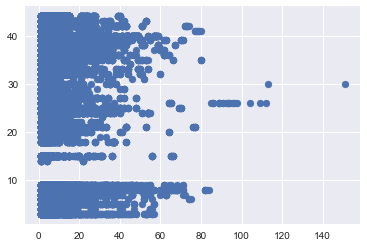

In [219]:
plt.scatter(df_visits[df_visits.TripType<999].no_of_items,df_visits[df_visits.TripType<999].TripType)

_ there is no correlation _

****
### Lets create a vector based on items 'department description'  and the 'scanned counts' in each visit

In [319]:
dept_list = df_walmart_1st_cleanse.DepartmentDescription.unique()

In [320]:
len(dept_list)

68

In [321]:
dept_list.sort()

In [322]:
grouped = df_walmart_1st_cleanse.groupby([df_walmart_1st_cleanse.VisitNumber])

In [323]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse.ScanCount.isnull()].head(5)#check there are no not null Scan Counts

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber


In [324]:
'''
this function builds a vector of department descriptions for each visit
*** input ***  
dept_dict - dictionary of department descriptions - all set to zero
dept_series - a Series of all the deparment descriptions for the given visit number
dect_scan_dict - dictionary of scan count ordered in the  same way as department desciptions - all set to zero
scan_series - a Series of all the scan count ordered in the same way as department description
v_num - visit number for which the vector that needs to be built
*** output ***
numpy array of the number of occurences of the departments, in the same order as dept_dict
numpy array of the scan counts, i.e., total scanned items for a particular department
'''
def buildDeptVector(dept_dict, dept_series, dept_scan_dict, scan_series, v_num):
    for i in range(0,len(dept_series)):
        if (dept_series.iloc[i] in dept_dict):
            dept_dict[dept_series.iloc[i]] = dept_dict[dept_series.iloc[i]] + 1
            dept_scan_dict[dept_series.iloc[i]] = dept_scan_dict[dept_series.iloc[i]]+scan_series.iloc[i]
    return np.array(list(dept_dict.values())),np.array(list(dept_scan_dict.values()))


In [325]:
dept_vect_dict = {}
dept_scan_vect_dict={}

In [326]:
new_df_list=[]
for name,group in grouped:
    dept_vect_dict=dept_vect_dict.fromkeys(dept_list,0)
    dept_scan_vect_dict = dept_scan_vect_dict.fromkeys(dept_list,0)
    #print('before call:',dept_vect_dict,':')
    np_dept_vect,np_dept_scan_vect = buildDeptVector(dept_vect_dict,group.DepartmentDescription,dept_scan_vect_dict,group.ScanCount,name)
    #print('after call:',dept_vect_dict,':')
    new_df_list.append([name,np_dept_vect,np_dept_scan_vect])


In [327]:
df_visit_dept_vector = pd.DataFrame.from_records(new_df_list)

In [328]:
df_visit_dept_vector.columns=['VisitNumber','DepartmentVector','ScanCounts']

In [180]:
#df_visit_dept_vector.iloc[2].DepartmentVector
#df_visit_dept_vector.iloc[2].ScanCounts

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 18, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [329]:
#check to see if we have got 95,516 visits
len(df_visit_dept_vector)

95516

In [295]:
df_visit_dept_vector[df_visit_dept_vector['VisitNumber']==72439]

,VisitNumber,DepartmentVector,ScanCounts
36196,72439,"[0, 0, 0, 0, 21, 5, 6, 0, 10, 0, 0, 0, 1, 0, 0...","[0, 0, 0, 0, 37, 7, 8, 0, 10, 0, 0, 0, 1, 0, 0..."


In [331]:
# concat the two dataframes df_visits and df_visit_dept_vector
df_visits = pd.concat([df_visits.set_index('VisitNumber'),df_visit_dept_vector.set_index('VisitNumber')],axis=1).sort_index()

In [338]:
df_visits.head(5)

,no_of_items,TripType,Day,DepartmentVector,ScanCounts
VisitNumber,,,,,
5,1,8.0,Monday,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,2,37.0,Sunday,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,22,999.0,Friday,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,3,40.0,Sunday,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,3,31.0,Sunday,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [ ]:
#df_walmart_1st_cleanse.Upc.value_counts().head(5000).sum()
#df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(df_walmart_1st_cleanse.Upc.value_counts().head(50))]

In [ ]:
#df_walmart_1st_cleanse.DepartmentDescription.value_counts()

In [ ]:
#sns.distplot(df_walmart_1st_cleanse.DepartmentDescription)